# Set-up

## Imports

In [1]:
# Standard
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# Plotting
import matplotlib.pyplot as plt
from matplotlib.cm import Blues
import matplotlib.colors as mcolors
plt.rcParams['savefig.dpi'] = 200
import seaborn as sns
sns.set_theme()

# Sci-kit learn imports
from sklearn.metrics import average_precision_score

## Parameters

In [26]:
scope = 'OFF'

input_path = f'../data/3_output/ML_dataset_{scope}.pkl'

start_month = 201901
end_month = 202212

subsample_size = None

target = 'Result'

## Functions

In [27]:
def APS(groupby, prob_col_name='y_probs'):
    non_nan_mask = ~groupby[[target, prob_col_name]].isna().any(axis=1)
    # if (~groupby[prob_col_name].isna()).sum() == 0:
    #     return np.nan
    if non_nan_mask.sum() == 0:
        return np.nan
    else:
        # return average_precision_score(groupby[target], groupby[prob_col_name])
        return average_precision_score(groupby.loc[non_nan_mask, target], groupby.loc[non_nan_mask, prob_col_name])

In [28]:
def get_APS_per_model(df, group_col, models, plot=True, plot_kind='bar', save=False, legend_loc=None, hide_xlabel=False, plot_baseline=True, **kwargs):
    group_df = df.groupby(group_col)
    aps_df = pd.DataFrame()
    for model in models:
        aps_df[model] = group_df.apply(lambda group: APS(group, prob_col_name=f'y_{model}')).rename({None: f'APS_{model}'})
    aps_df.index = aps_df.index.astype(str)
    if plot:
        aps_df.plot(kind=plot_kind, **kwargs)
        if plot_baseline:
            # baseline = df.Result.sum() / len(df)
            baseline = group_df['Result'].mean()
            # baseline.index = baseline.index.astype(str)
            # plt.axhline(y=baseline, linestyle='--', color='grey', linewidth=1)
            plt.plot(baseline.index.astype(str), baseline.values, linestyle='--', color='grey', linewidth=1)
        if hide_xlabel:
            plt.xlabel(None)
        else:
            plt.xlabel(group_col)
        plt.xticks(rotation=0)
        plt.ylabel('AUC-PR')
        plt.ylim((0,1))
        # plt.title('Models performance for {} bids per {}'.format(scope, group_col))
        if legend_loc:
            plt.legend(loc=legend_loc)
        if save:
            plt.savefig('../plots/{}/models_comparison/{}_aps_{}_{}.png'.format(scope, '_'.join(models), group_col, scope.lower()))
        plt.show()
    return aps_df

# Main

## Load dataset

In [29]:
# Load dataset
input_df = pd.read_pickle(input_path)
df = input_df.copy()
# Select only observations for which we generated a prediction
df['yearmonth'] = df.index.str[:6].astype(int)
df['month'] = df.index.str[4:6].astype(int)
df = df[(df.yearmonth >= start_month) & (df.yearmonth <= end_month)]
df

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,WorkDay,Prov,Tech,PVold,PVnew,Price,PriceDiff,Result,yearmonth,month
201901011UP_ACTV_1_OFF,1,20190101,2019,UP_ACTV_1,OFF,1.987508,-0.446966,-2.921364,-0.137306,-0.401592,...,holiday,Vercelli,Thermoelectric,0.000,0.000,130.0,0.436,False,201901,1
201901012UP_ACTV_1_OFF,2,20190101,2019,UP_ACTV_1,OFF,2.992812,0.367096,-3.134924,0.025819,-0.401592,...,holiday,Vercelli,Thermoelectric,0.000,0.000,130.0,0.475,False,201901,1
201901013UP_ACTV_1_OFF,3,20190101,2019,UP_ACTV_1,OFF,5.121951,-2.372232,-3.379947,0.027554,-0.401592,...,holiday,Vercelli,Thermoelectric,0.000,0.000,130.0,0.531,False,201901,1
201901014UP_ACTV_1_OFF,4,20190101,2019,UP_ACTV_1,OFF,3.023857,-0.063917,-3.585943,-0.011441,-0.401592,...,holiday,Vercelli,Thermoelectric,0.000,0.000,130.0,0.647,False,201901,1
201901015UP_ACTV_1_OFF,5,20190101,2019,UP_ACTV_1,OFF,3.785303,2.527202,-3.723609,0.051985,-0.401592,...,holiday,Vercelli,Thermoelectric,0.000,0.000,130.0,0.711,False,201901,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022123117UP_VOGHERA_1_OFF,17,20221231,2022,UP_VOGHERA_1,OFF,0.237656,-2.008471,-1.806319,0.875068,-2.527147,...,holiday,Pavia,Fossil Gas,0.540,0.540,320.0,0.066,False,202212,12
2022123121UP_VOGHERA_1_OFF,21,20221231,2022,UP_VOGHERA_1,OFF,-0.075154,-0.954465,-1.872673,0.745683,-2.449869,...,holiday,Pavia,Fossil Gas,0.573,0.573,320.0,0.016,False,202212,12
2022123122UP_VOGHERA_1_OFF,22,20221231,2022,UP_VOGHERA_1,OFF,2.244316,-3.847872,-2.345759,0.833482,-2.547642,...,holiday,Pavia,Fossil Gas,0.526,0.526,320.0,0.085,False,202212,12
2022123123UP_VOGHERA_1_OFF,23,20221231,2022,UP_VOGHERA_1,OFF,2.277886,-3.849805,-2.698679,0.834434,-2.527069,...,holiday,Pavia,Fossil Gas,0.525,0.525,320.0,0.190,False,202212,12


## Load predictions

### RF

In [30]:
years = [2018, 2019, 2020, 2021, 2022]
for year in years[:-1]:
    test_years = '_'.join([str(y) for y in years if y > year])
    df[f'y_RF{year}'] = pd.read_pickle(f'{scope}/model_predictions/RF_predicted_probs_train_{year}_test_{test_years}.pkl')

### RF monthly recal 12 months

In [31]:
df['y_RFrecal'] = pd.read_pickle(f'{scope}/model_predictions/RF_predicted_probs_monthly_recal_rolling_12m.pkl')

### GLM monthly recal 12 months

In [32]:
df['y_GLMrecal'] = pd.read_csv(f'{scope}/model_predictions/GLM_predicted_probs_monthly_recal_rolling_12m.csv', index_col=0)['y_probs']

### HP monthly recal 12 months

In [33]:
df['y_HPrecal'] = pd.read_pickle(f'{scope}/model_predictions/HP_predicted_probs_monthly_recal_rolling_12m.pkl')

In [34]:
df

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,Result,yearmonth,month,y_RF2018,y_RF2019,y_RF2020,y_RF2021,y_RFrecal,y_GLMrecal,y_HPrecal
201901011UP_ACTV_1_OFF,1,20190101,2019,UP_ACTV_1,OFF,1.987508,-0.446966,-2.921364,-0.137306,-0.401592,...,False,201901,1,0.00,NaN,NaN,NaN,0.000,0.000578,0.020582
201901012UP_ACTV_1_OFF,2,20190101,2019,UP_ACTV_1,OFF,2.992812,0.367096,-3.134924,0.025819,-0.401592,...,False,201901,1,0.00,NaN,NaN,NaN,0.000,0.000563,0.014158
201901013UP_ACTV_1_OFF,3,20190101,2019,UP_ACTV_1,OFF,5.121951,-2.372232,-3.379947,0.027554,-0.401592,...,False,201901,1,0.00,NaN,NaN,NaN,0.000,0.000555,0.012246
201901014UP_ACTV_1_OFF,4,20190101,2019,UP_ACTV_1,OFF,3.023857,-0.063917,-3.585943,-0.011441,-0.401592,...,False,201901,1,0.00,NaN,NaN,NaN,0.000,0.000285,0.006654
201901015UP_ACTV_1_OFF,5,20190101,2019,UP_ACTV_1,OFF,3.785303,2.527202,-3.723609,0.051985,-0.401592,...,False,201901,1,0.00,NaN,NaN,NaN,0.000,0.000288,0.005512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022123117UP_VOGHERA_1_OFF,17,20221231,2022,UP_VOGHERA_1,OFF,0.237656,-2.008471,-1.806319,0.875068,-2.527147,...,False,202212,12,0.22,0.13,0.16,0.34,0.380,0.187540,0.098319
2022123121UP_VOGHERA_1_OFF,21,20221231,2022,UP_VOGHERA_1,OFF,-0.075154,-0.954465,-1.872673,0.745683,-2.449869,...,False,202212,12,0.23,0.14,0.18,0.30,0.435,0.284854,0.086938
2022123122UP_VOGHERA_1_OFF,22,20221231,2022,UP_VOGHERA_1,OFF,2.244316,-3.847872,-2.345759,0.833482,-2.547642,...,False,202212,12,0.26,0.16,0.26,0.35,0.415,0.272070,0.062058
2022123123UP_VOGHERA_1_OFF,23,20221231,2022,UP_VOGHERA_1,OFF,2.277886,-3.849805,-2.698679,0.834434,-2.527069,...,False,202212,12,0.30,0.22,0.30,0.26,0.400,0.222744,0.048416


## Compare performances

### RF years vs Monthly Recal

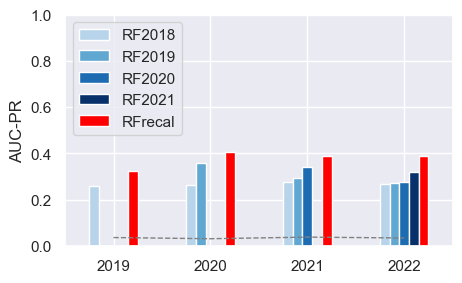

,RF2018,RF2019,RF2020,RF2021,RFrecal
year,,,,,
2019,0.259715,NaN,NaN,NaN,0.325270
2020,0.261575,0.359852,NaN,NaN,0.407729
2021,0.278014,0.293212,0.340187,NaN,0.388073
2022,0.268143,0.271118,0.277765,0.318804,0.389153


In [35]:
models = ['RF2018', 'RF2019', 'RF2020', 'RF2021', 'RFrecal']
colors = [Blues(value) for value in np.linspace(0.3, 1, 4)] + [mcolors.to_rgba('red')]
get_APS_per_model(df, 'year', models, color=colors, figsize=(5, 3), hide_xlabel=True, save=True, legend_loc='upper left')

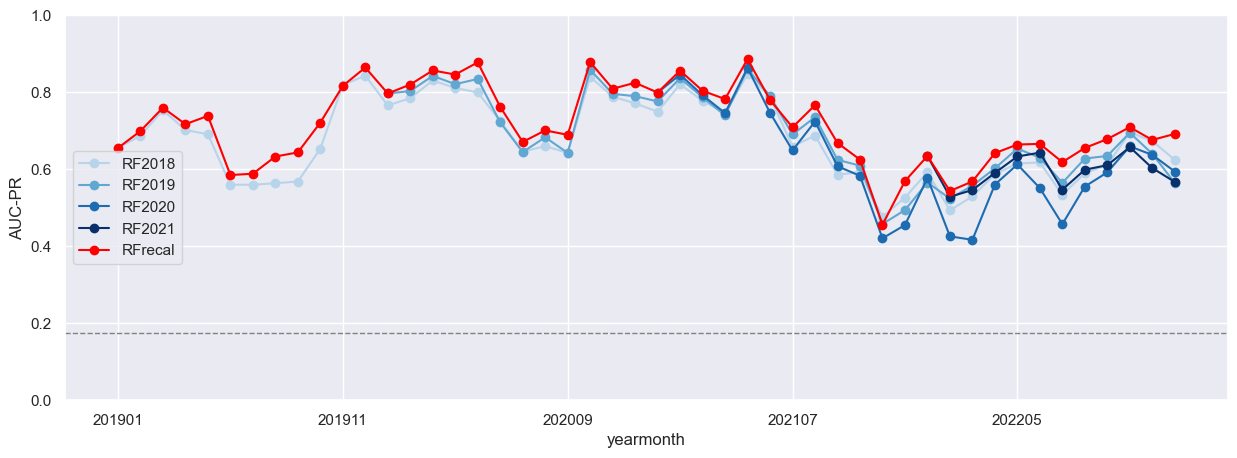

In [16]:
models = ['RF2018', 'RF2019', 'RF2020', 'RF2021', 'RFrecal']
colors = [Blues(value) for value in np.linspace(0.3, 1, 4)] + [mcolors.to_rgba('red')]
aps_df = get_APS_per_model(df, 'yearmonth', models, plot_kind='line', figsize=(15,5), marker='o', color=colors, save=True)

### RF vs others

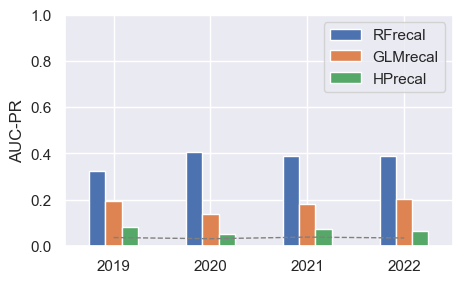

,RFrecal,GLMrecal,HPrecal
year,,,
2019,0.325270,0.196031,0.079529
2020,0.407729,0.138133,0.052772
2021,0.388073,0.179766,0.073092
2022,0.389153,0.204212,0.066046


In [36]:
models = ['RFrecal', 'GLMrecal', 'HPrecal']
get_APS_per_model(df, 'year', models, hide_xlabel=True, figsize=(5,3), save=True)

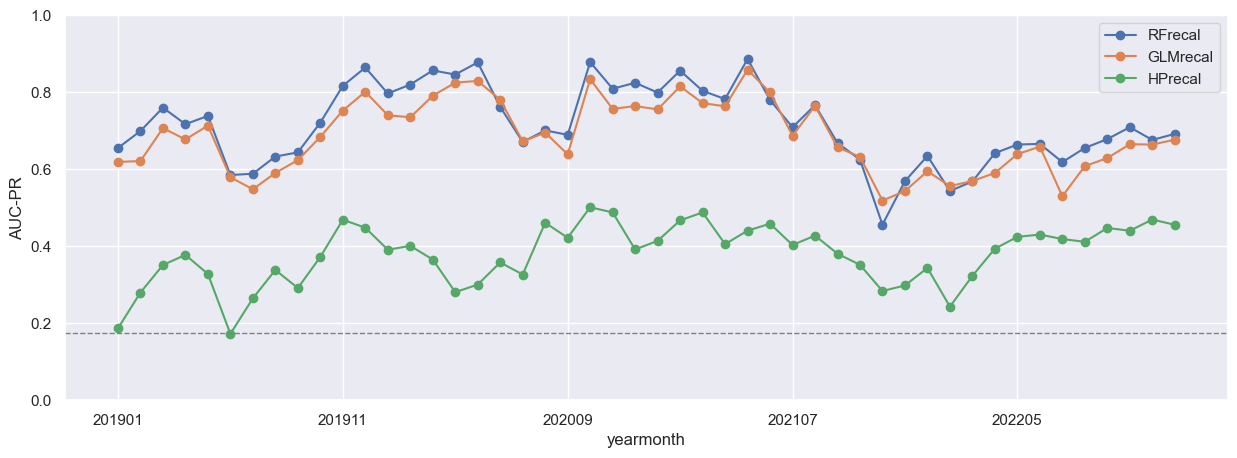

In [18]:
aps_df = get_APS_per_model(df, 'yearmonth', models, plot_kind='line', figsize=(15,5), marker='o')

<HR>

# TESTS

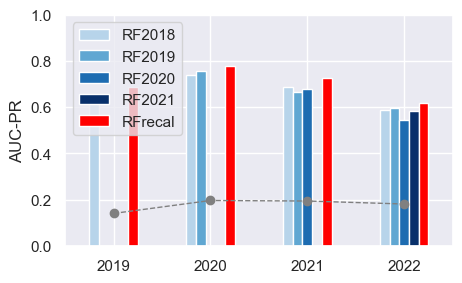

,RF2018,RF2019,RF2020,RF2021,RFrecal
year,,,,,
2019,0.657555,NaN,NaN,NaN,0.689449
2020,0.740621,0.757111,NaN,NaN,0.780490
2021,0.689303,0.666915,0.679090,NaN,0.724453
2022,0.586660,0.595128,0.545222,0.583874,0.618592


In [22]:
models = ['RF2018', 'RF2019', 'RF2020', 'RF2021', 'RFrecal']
colors = [Blues(value) for value in np.linspace(0.3, 1, 4)] + [mcolors.to_rgba('red')]
get_APS_per_model(df, 'year', models, color=colors, figsize=(5, 3), hide_xlabel=True, save=False, legend_loc='upper left')